In [1]:
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# I need to clean up all my python kernals b/c this really should run within py3 and not py2
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
# Read the data saved in my local /data/
# Remember to upload these as part of the assignment
with open('../data/Coaches.csv', 'rb') as f:
    coaches = pd.read_csv(f).fillna(0)

with open('../data/stadiums-geocoded.csv', 'rb') as f:
    stadium = pd.read_csv(f).fillna(0)

with open('../data/graduation-rates.csv', 'rb') as f:
    grad_rates = pd.read_csv(f).fillna(0)

with open('../data/2017-season.csv', 'rb') as f:
    season_2017 = pd.read_csv(f).fillna(0)

In [3]:
# Cleaning
# Num Cols
stadium_numerical = ['capacity', 'built', 'expanded']
grad_numerical = ['gsr', 'fgr']
season_numerical = ['win', 'loss', 'pct']
coaches_numerical = [
    'schoolpay',
    'totalpay',
    'bonus',
    'bonuspaid',
    'assistantpay',
    'buyout'
]

# lowercase
coaches = coaches.apply(lambda x: x.astype(str).str.lower())
stadium = stadium.apply(lambda x: x.astype(str).str.lower())
grad_rates = grad_rates.apply(lambda x: x.astype(str).str.lower())
season_2017 = season_2017.apply(lambda x: x.astype(str).str.lower())

# col names to lowercase
coaches.columns = coaches.columns.str.lower()
stadium.columns = stadium.columns.str.lower()
grad_rates.columns = grad_rates.columns.str.lower()
season_2017.columns = season_2017.columns.str.lower()

# remove non-numeric to empty space
coaches[coaches_numerical] = coaches[coaches_numerical].replace('[\$,--]', '', regex=True)

# convert column name - play nice with df merge
stadium = stadium.rename(columns={'team': 'school'})

# $$ to numeric
stadium[stadium_numerical] = stadium[stadium_numerical].apply(
    pd.to_numeric,
    errors='coerce',
    axis=1
).fillna(0)

# $$ to numeric
coaches[coaches_numerical] = coaches[coaches_numerical].apply(
    pd.to_numeric,
    errors='coerce',
    axis=1
).fillna(0)

# grad_rates to numeric
grad_rates[grad_numerical] = grad_rates[grad_numerical].apply(
    pd.to_numeric,
    errors='coerce',
    axis=1
).fillna(0)

# coerce season rate to numeric
season_2017[season_numerical] = season_2017[season_numerical].apply(
    pd.to_numeric,
    errors='coerce',
    axis=1
).fillna(0)

In [4]:
stadium = stadium[['stadium', 'school'] + stadium_numerical]

# replace acronym with school name
stadium['school'] = stadium['school'].replace(['ucf'], 'central florida')
stadium['school'] = stadium['school'].replace(['usf'], 'south florida')
stadium['school'] = stadium['school'].replace(['utsa'], 'texas-san antonio')
stadium['school'] = stadium['school'].replace(['byu'], 'brigham young')
stadium['school'] = stadium['school'].replace(['utep'], 'texas-el paso')
stadium['school'] = stadium['school'].replace(['tcu'], 'texas christian')
stadium['school'] = stadium['school'].replace(['unlv'], 'nevada-las vegas')
stadium['school'] = stadium['school'].replace(['smu'], 'southern methodist')
stadium['school'] = stadium['school'].replace(['niu'], 'northern illinois')
stadium['school'] = stadium['school'].replace(['miami (oh)'], 'miami (ohio)')
stadium['school'] = stadium['school'].replace(['fiu'], 'florida international')
stadium['school'] = stadium['school'].replace(['umass'], 'massachusetts')
stadium['school'] = stadium['school'].replace(['yale bulldogs'], 'connecticut')

# stadium pre 2007: attraining stadium data after 2006, will not
#      join with the grad_rates dataframe, since the 2006 cohort
#      is the focus.
#
stadium = stadium[stadium['expanded'] <= 2006]

In [5]:
# merge coaches + stadium
merged_df = pd.merge(coaches, stadium, on='school', how='inner')

# merge graduation rates
merged_df = pd.merge(merged_df, grad_rates, on='school', how='inner')

# merge 2017 season
merged_df = pd.merge(merged_df, season_2017, on='school', how='inner')

In [6]:
# Model prep
# local variables
lin_reg = linear_model.LinearRegression()

# split train + test
train, test = train_test_split(merged_df, test_size=0.33)

#
# train model
#
y_train = train[['schoolpay']]
X_train = train[['capacity', 'gsr', 'pct']]
lin_reg.fit(X_train, y_train)

#
# predict
#
y_test = test[['schoolpay']]
X_test = test[['capacity', 'gsr', 'pct']]
y_pred = lin_reg.predict(X_test)

In [10]:
# predict syracuse salary
target = merged_df[merged_df['school'] == 'syracuse']
sal_num = lin_reg.predict(target[['capacity', 'gsr', 'pct']])
print sal_num

[[2081669.53657188]]


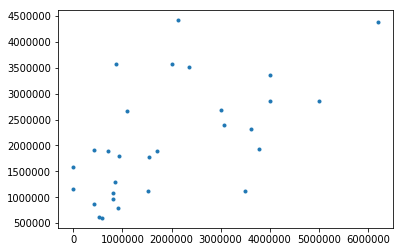

In [11]:
# prediction vs actual data
plt.plot(y_test, y_pred, '.')

In [12]:
print('model coefficients: {}\nmodel intercept: {}\nmean squared error: {}\nrsquared: {}'.format(
    lin_reg.coef_,
    lin_reg.intercept_,
    mean_squared_error(y_test, y_pred),
    r2_score(y_test, y_pred)
))

model coefficients: [[6.02908011e+01 8.72871716e+03 6.73616578e+05]]
model intercept: [-1784302.49731568]
mean squared error: 1.68402911644e+12
rsquared: 0.330370239918


In [13]:
# train ols
est = sm.OLS(y_train, X_train)
ols_reg = est.fit()
print(ols_reg.summary())

                                 OLS Regression Results                                
Dep. Variable:              schoolpay   R-squared (uncentered):                   0.836
Model:                            OLS   Adj. R-squared (uncentered):              0.827
Method:                 Least Squares   F-statistic:                              91.83
Date:                Sat, 25 Jul 2020   Prob (F-statistic):                    3.38e-21
Time:                        20:16:13   Log-Likelihood:                         -876.54
No. Observations:                  57   AIC:                                      1759.
Df Residuals:                      54   BIC:                                      1765.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

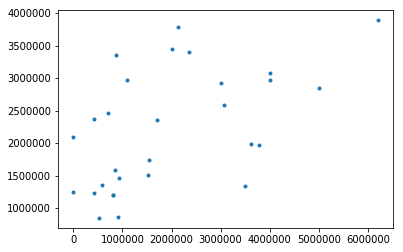

In [14]:
# plot ols
ols_pred = ols_reg.predict(X_test)
plt.plot(y_test, ols_pred, '.')

In [15]:
# predict ols
ols_reg.predict(target[['capacity', 'gsr', 'pct']])

68    2.219865e+06
dtype: float64

In [16]:
# big 10: split train + test
train_big10, test_big_10 = train_test_split(merged_df[merged_df['conference'] == 'big ten'], test_size=0.33)

#
# big 10: train model
#
y_train_big10 = train_big10[['schoolpay']]
X_train_big10 = train_big10[['capacity', 'gsr', 'pct']]

In [17]:
# big 10: train ols

est_big10 = sm.OLS(y_train_big10, X_train_big10)
ols_reg_big10 = est_big10.fit()
print(ols_reg_big10.summary())

                                 OLS Regression Results                                
Dep. Variable:              schoolpay   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                              171.5
Date:                Sat, 25 Jul 2020   Prob (F-statistic):                      0.0561
Time:                        20:20:23   Log-Likelihood:                         -53.661
No. Observations:                   4   AIC:                                      113.3
Df Residuals:                       1   BIC:                                      111.5
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/opt/anaconda2/lib/python2.7/site-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)


In [18]:
# big 10: predict ols
ols_reg_big10.predict(target[['capacity', 'gsr', 'pct']])

68    4.332287e+06
dtype: float64